# Results 5 June

In [1]:
from tools import *
import pandas as pd
import seaborn as sns
from matplotlib import cm
from scipy.stats import ks_2samp
from IPython.display import display
style.use('ggplot')
d = manual_load_data('clean_data.pkl')
%config InlineBackend.figure_format = 'retina'

In [2]:
markers = {}
markers['P07'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P08'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P09'] = {'index': 'index7', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P11'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P12'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P16'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist12'}
markers['P18'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P19'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}

pd.DataFrame(markers)

,P07,P08,P09,P11,P12,P16,P18,P19
index,index8,index8,index7,index8,index8,index8,index8,index8
thumb,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9
wrist,wrist11,wrist11,wrist11,wrist11,wrist11,wrist12,wrist11,wrist11


## Distance to object's centre for index & gaze

In [3]:
accuracies = pd.DataFrame()

for pid, subj in d.items():
    
    index_x = markers[pid]['index'] + 'x'
    wrist_vel = markers[pid]['wrist'] + 'vel'
    
    for tid, trial in subj['trials'].items():
        
        # identify the reach onset frame
        sm = np.array(trial['startmovement'])
        ro_frame = np.where(sm == 1)[0][0]
        
        # get the fixations table for a trial
        fix = pd.DataFrame(trial['fix'])
                
        # find the eye and index to object distances
        index_object = trial[index_x][-1] - trial['objectx'][-1]
        eyes_object_final = fix.iloc[-1]['centre_x'] - trial['objectx'][-1] # final fixation in a trial
        
        ro_fix = fix[(fix['start_frame'] <= ro_frame) & (fix['end_frame'] >= ro_frame)]
        
        if not ro_fix['centre_x'].any():
            ro_fix_x = fix[fix['start_frame'] >= ro_frame]['centre_x'].iloc[0]
        else:
            ro_fix_x = ro_fix['centre_x'].iloc[0]
            
        eyes_object_ro = ro_fix_x - trial['objectx'][ro_frame]
        
        if 'RightToLeft' in trial['name']:
            index_object *= -1
            eyes_object_final *= -1
            eyes_object_ro *= -1
            
        # reach duration in frames
        reach_duration = len(np.where(sm == 1)[0])
        
        # peak velocity frame
        vel = np.array(trial[wrist_vel])
        peak_vel = np.where(vel == max(vel))[0][0]
        
        # wrist deceleration time in frames
        wrist_decel = len(vel[peak_vel:])
        
        # reaction time: reach initiation frame - tone frame (880 is when the tone starts to play)
        reaction = ro_frame - 880
            
        cond = trial['name'][6:-4]
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['condition'] = cond
        to_add['trial'] = tid
        to_add['ro_frame'] = ro_frame
        to_add['reach_duration'] = reach_duration
        to_add['peak_vel'] = peak_vel
        to_add['wrist_decel'] = wrist_decel
        to_add['reaction'] = reaction
        to_add['index_object'] = index_object
        to_add['eyes_object_final'] = eyes_object_final
        to_add['eyes_object_ro'] = eyes_object_ro

        
        accuracies = accuracies.append(to_add, ignore_index = True)

In [4]:
accuracies[accuracies['p'] == 'P11'].sort_values(by = 'condition')

,condition,eyes_object_final,eyes_object_ro,index_object,p,peak_vel,reach_duration,reaction,ro_frame,trial,wrist_decel
26,Occlusion_Cue_LeftToRight,-0.043045,-0.008489,-0.056773,P11,948.0,67.0,40.0,920.0,t6,39.0
28,Occlusion_Cue_LeftToRight,-0.050904,-0.010312,-0.064723,P11,950.0,68.0,41.0,921.0,t4,39.0
29,Occlusion_Cue_LeftToRight,-0.048320,-0.012685,-0.050621,P11,953.0,70.0,46.0,926.0,t5,43.0
30,Occlusion_Cue_LeftToRight,-0.052034,-0.022108,-0.063472,P11,962.0,77.0,50.0,930.0,t2,45.0
31,Occlusion_Cue_LeftToRight,-0.053332,-0.014381,-0.061573,P11,949.0,69.0,44.0,924.0,t3,44.0
24,Occlusion_Cue_RightToLeft,-0.064803,-0.033644,-0.060382,P11,955.0,71.0,52.0,932.0,t8,48.0
35,Occlusion_Cue_RightToLeft,-0.027019,-0.023037,-0.023688,P11,959.0,91.0,51.0,931.0,t7,63.0
13,Occlusion_Cue_RightToLeft,-0.041178,0.010860,-0.032229,P11,959.0,80.0,48.0,928.0,t12,49.0
12,Occlusion_Cue_RightToLeft,-0.042300,-0.000159,-0.043283,P11,966.0,82.0,57.0,937.0,t11,53.0
25,Occlusion_Cue_RightToLeft,-0.057467,-0.035653,-0.044897,P11,971.0,72.0,61.0,941.0,t9,42.0


In [5]:
inter1 = accuracies.groupby(['p', 'condition']).aggregate(np.mean)
inter2 = inter1.reset_index(level = ['condition'])
meanPerCondition = inter2.groupby('condition').aggregate(np.mean)

meanPerCondition

,eyes_object_final,eyes_object_ro,index_object,peak_vel,reach_duration,reaction,ro_frame,wrist_decel
condition,,,,,,,,
Occlusion_Cue_LeftToRight,-0.067852,-0.040095,-0.063727,956.368750,75.237500,43.814583,923.814583,42.843750
Occlusion_Cue_RightToLeft,-0.069068,-0.034944,-0.058095,963.860417,88.783333,49.068750,929.068750,54.710417
Occlusion_NoCue_LeftToRight,-0.068916,-0.041370,-0.064395,954.820833,74.650000,42.222917,922.222917,42.277083
Occlusion_NoCue_RightToLeft,-0.071122,-0.041036,-0.062168,958.979167,86.195833,48.175000,928.175000,55.733333
Visible_Cue_LeftToRight,-0.023106,-0.004008,-0.012636,949.731250,71.745833,38.472917,918.472917,40.570833
Visible_Cue_RightToLeft,-0.009367,0.005277,-0.004167,959.837500,81.566667,44.604167,924.604167,46.333333
Visible_NoCue_LeftToRight,-0.030237,-0.003767,-0.011450,949.595833,69.820833,39.191667,919.191667,39.500000
Visible_NoCue_RightToLeft,-0.010992,0.005374,-0.004883,959.410417,82.685417,44.050000,924.050000,47.412500


In [6]:
inter3 = inter1.reset_index(level = ['p', 'condition'])
anovaTable = inter3.pivot(index = 'p', columns = 'condition', values = 'index_object')

### Accuracy per condition

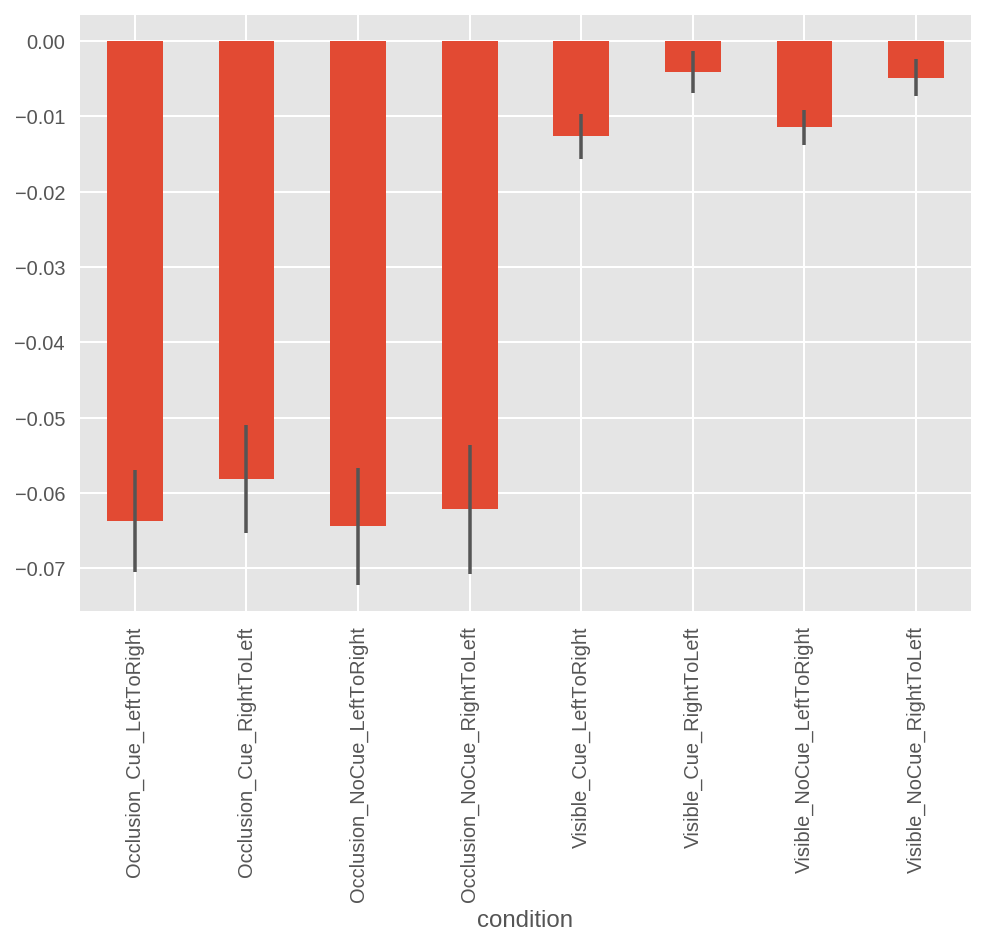

In [7]:
anovaTable.mean(axis = 0).plot(kind = 'bar', yerr = anovaTable.std(axis = 0) / np.sqrt(len(anovaTable)))
plt.show()

### Accuracy per participant

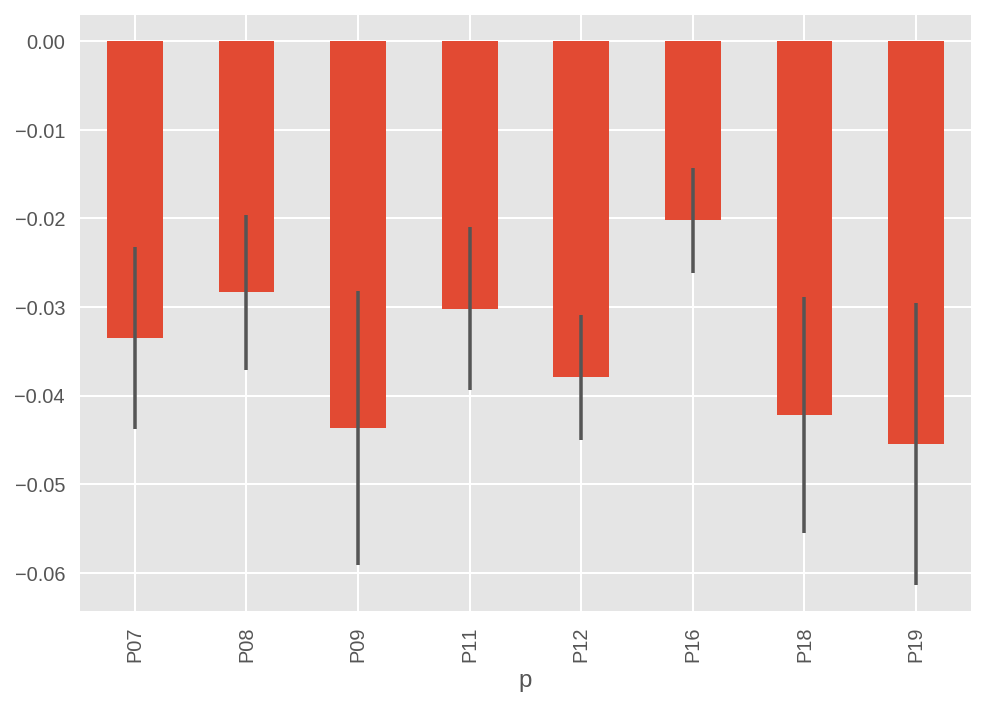

In [8]:
anovaTable.mean(axis = 1).plot(kind = 'bar', yerr = anovaTable.std(axis = 1) / np.sqrt(len(anovaTable.columns)))
plt.show()

## Fixations

In [9]:
cues = [0.353 + n * 0.072 for n in range(8)]
print cues

[0.353, 0.425, 0.497, 0.569, 0.641, 0.713, 0.7849999999999999, 0.857]


In [10]:
# Create a common fixations table

fixations = pd.DataFrame()

for pid, subj in d.items():
    
    index_x = markers[pid]['index'] + 'x'

    for tid, trial in subj['trials'].items():
        
        to_add = pd.DataFrame(trial['fix'])
        
        # identify the reach onset frame
        sm = trial['startmovement']
        ro_frame = np.where(np.array(sm) == 1)[0][0]
                
        # find the eye and index to object distances
        index_object = trial[index_x][-1] - trial['objectx'][-1]
        eyes_object_final = to_add.iloc[-1]['centre_x'] - trial['objectx'][-1] # final fixation in a trial
        
        ro_fix = to_add[(to_add['start_frame'] <= ro_frame) & (to_add['end_frame'] >= ro_frame)]
        if not ro_fix['centre_x'].any():
            ro_fix = to_add[to_add['start_frame'] >= ro_frame].iloc[0]
            
        eyes_object_ro = ro_fix['centre_x'] - trial['objectx'][ro_frame]
        
        if 'RightToLeft' in trial['name']:
            index_object *= -1
            eyes_object_final *= -1
            eyes_object_ro *= -1
        
        # identify the last fixation in a trial (or just the last row)
        to_add['time_interval'] = None
        to_add.loc[to_add.index[-1], 'time_interval'] = 3
        
        # add the data
        to_add['p'] = pid
        to_add['condition'] = trial['name'][6:-4]
        to_add['trial'] = tid
        to_add['ro_frame'] = ro_frame
        to_add['index_object'] = index_object
        to_add['eyes_object_final'] = eyes_object_final
        to_add['eyes_object_ro'] = eyes_object_ro
        
        # remove the dispersion column
        to_add.drop('dispersion', axis = 1, inplace = True)
 
        fixations = fixations.append(to_add, ignore_index = True)
        
# fixations = fixations[['p', 'condition', 'trial', 'centre_x', 'centre_z', 'duration', 'start_frame', 'end_frame',
#                        'ro_frame', 'time_interval']]


In [11]:
fixations[:10]

,centre_x,centre_z,duration,end_frame,start_frame,time_interval,p,condition,trial,ro_frame,index_object,eyes_object_final,eyes_object_ro
0,0.620333,0.316477,0.184615,44,21,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
1,0.782368,0.313448,0.153846,74,55,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
2,0.818304,0.321310,0.130769,93,77,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
3,0.819878,0.321702,0.123077,109,94,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
4,0.824741,0.326223,0.200000,135,110,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
5,0.836243,0.323640,0.823077,242,136,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
6,0.792765,0.324189,0.115385,292,278,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
7,0.783843,0.325048,0.115385,307,293,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
8,0.773689,0.324175,0.176923,330,308,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812
9,0.765588,0.325510,0.323077,372,331,None,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812


In [12]:
# Determine the time interval 
# 0 = before occlusion. frames 0-495
# 1 = visual pursuit. frames 496 - reach onset
# 2 = reach onset - time of contact-1
# 3 = time of contact

time_interval = []

for index, row in fixations.iterrows():
    if row['time_interval'] == 3:
        time_interval.append(3)
        continue
    elif row['start_frame'] <= 495:
        time_interval.append(0)
    elif 495 < row['start_frame'] < row['ro_frame']:
        time_interval.append(1)
    elif row['start_frame'] >= row['ro_frame']:
        time_interval.append(2)

fixations['time_interval'] = time_interval

In [13]:
# Detect the off-screen outliers

fixations['off_screen'] = (fixations.centre_x < 0.34) | (fixations.centre_x > 0.87) | \
    (fixations.centre_z < 0.18) | (fixations.centre_z > 0.48)
    
fixations['off_screen'].value_counts()

False    11102
True        40
Name: off_screen, dtype: int64

In [14]:
# Find the distances between fixations and the closest cue

closest_cue = []
distance = []

for index, row in fixations.iterrows():
    dist = [row['centre_x'] - cue for cue in cues]
    ind, = np.where(np.abs(dist) == min(np.abs(dist)))
    closest_cue.append(ind[0])
    distance.append(dist[ind[0]])
    
fixations['closest_cue'] = closest_cue
fixations['distance_to'] = distance

fixations[:5]

,centre_x,centre_z,duration,end_frame,start_frame,time_interval,p,condition,trial,ro_frame,index_object,eyes_object_final,eyes_object_ro,off_screen,closest_cue,distance_to
0,0.620333,0.316477,0.184615,44,21,0,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812,False,4,-0.020667
1,0.782368,0.313448,0.153846,74,55,0,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812,False,6,-0.002632
2,0.818304,0.321310,0.130769,93,77,0,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812,False,6,0.033305
3,0.819878,0.321702,0.123077,109,94,0,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812,False,6,0.034878
4,0.824741,0.326223,0.200000,135,110,0,P11,Visible_NoCue_RightToLeft,t48,934,-0.006412,-0.003787,0.016812,False,7,-0.032259


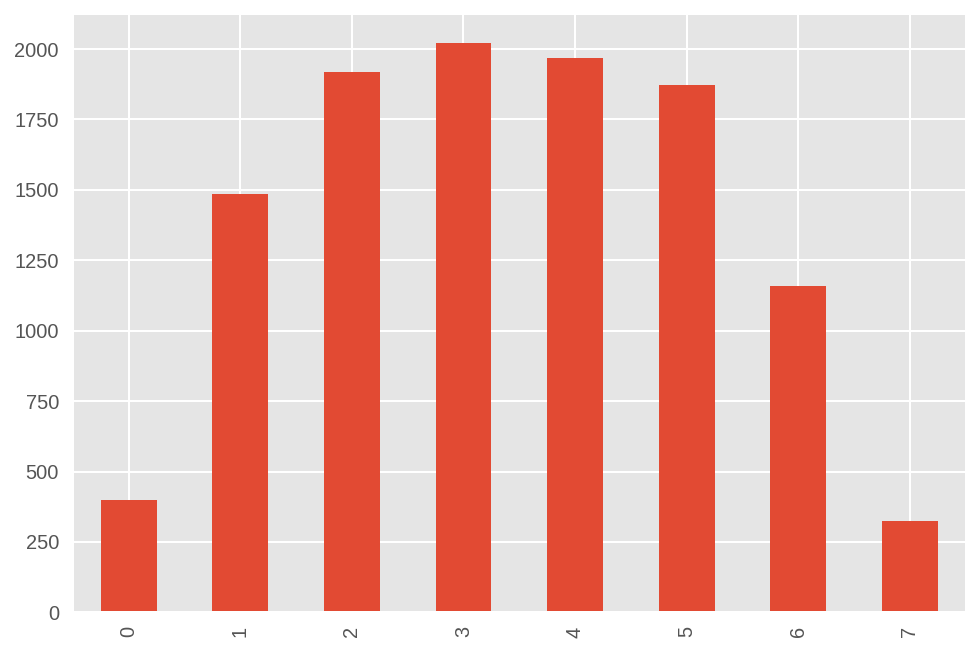

In [15]:
# Number of fixations per closest cue

fixations['closest_cue'].value_counts(sort = False).plot(kind = 'bar')
plt.show()

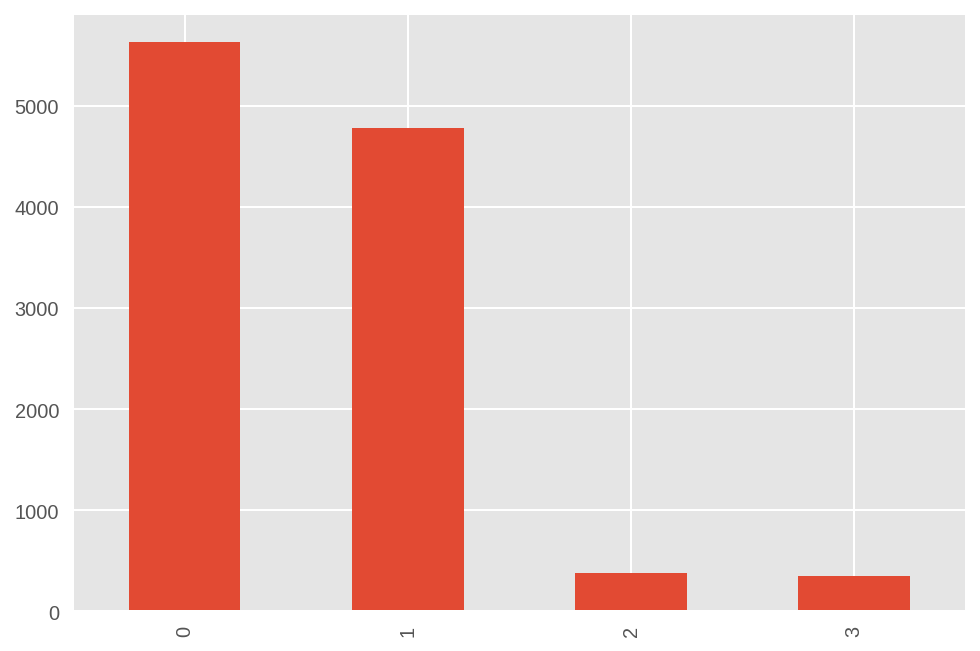

In [16]:
# Number of fixations in the time intervals

fixations['time_interval'].value_counts(sort = False).plot(kind = 'bar')
plt.show()

### Fixations' location during visual pursuit

In [17]:
# Fixations for occlusion, cue vs no cue, left to right


ocl_fixations = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 1)]


onl_fixations = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 1)]


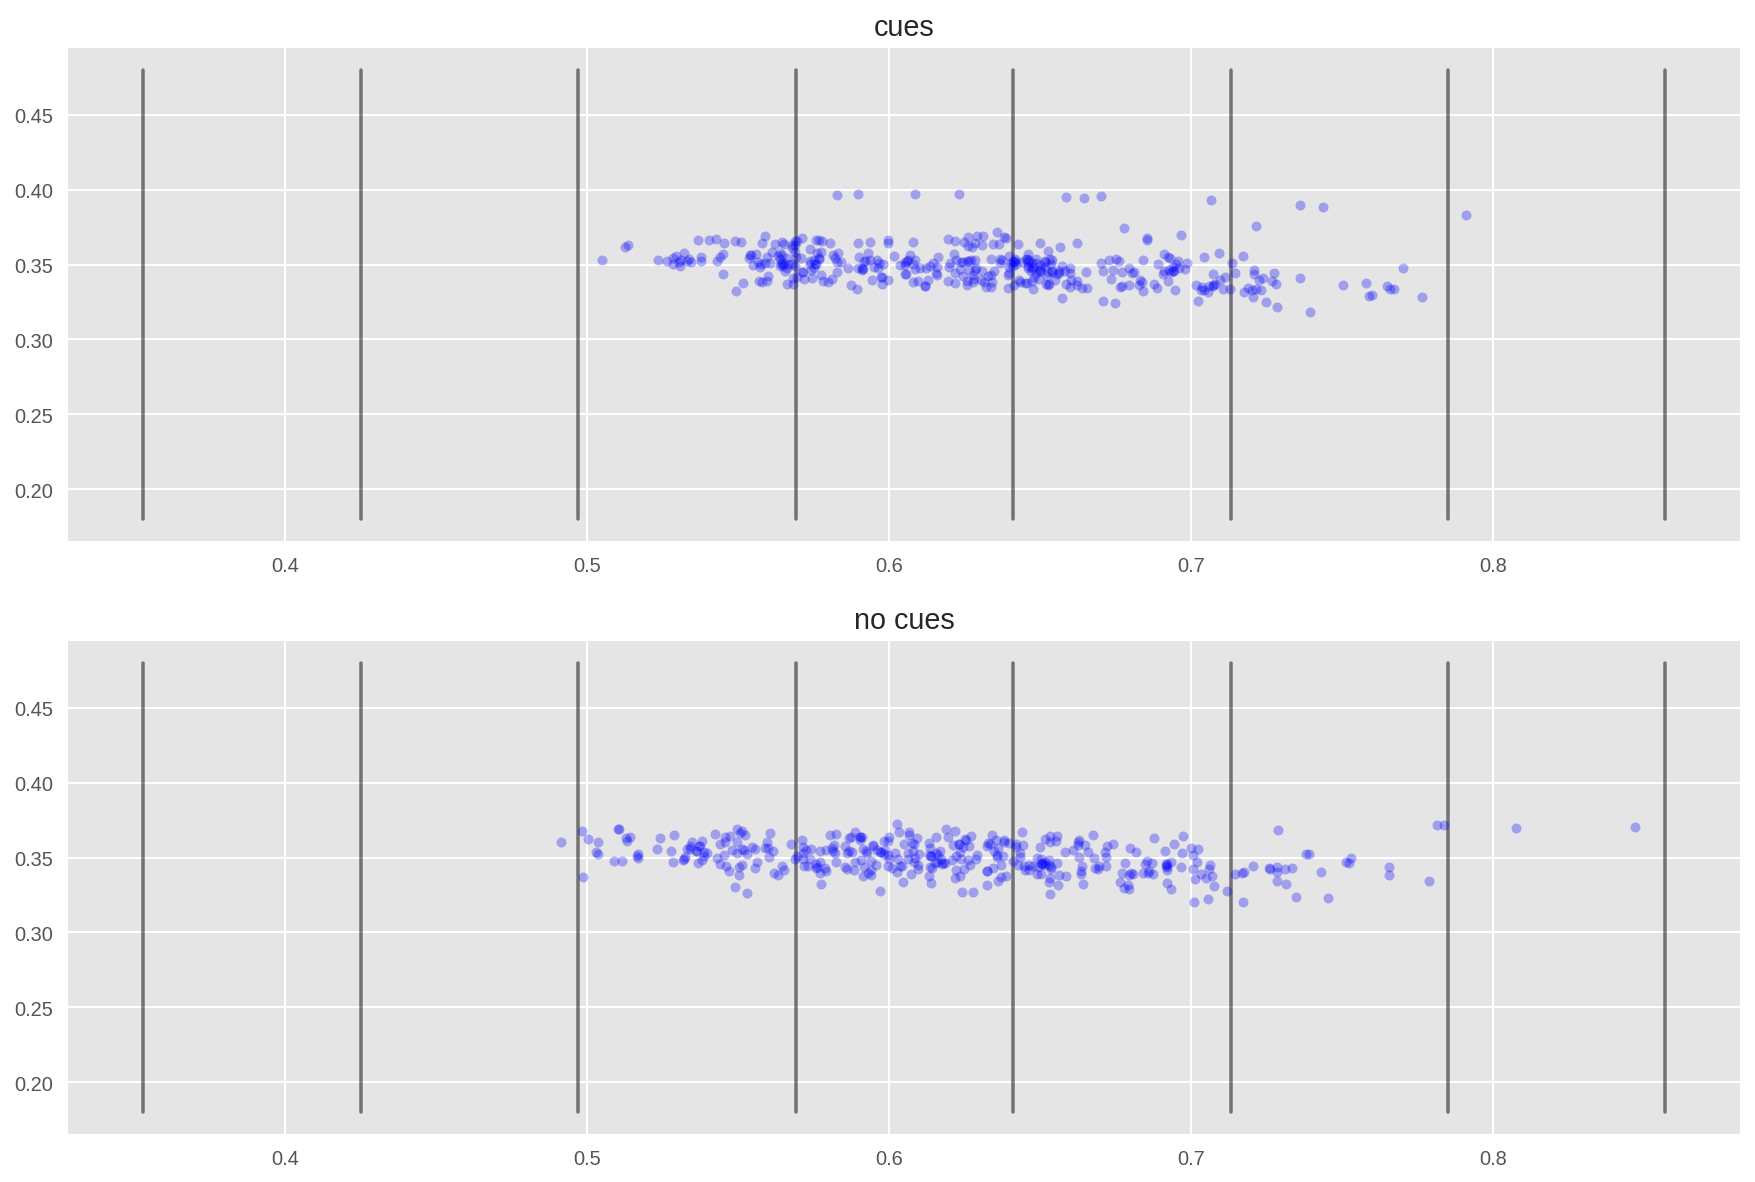

In [18]:
fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.plot(ocl_fixations['centre_x'], ocl_fixations['centre_z'], 'b.', alpha = 0.3, markersize = 10)
ax1.set_title('cues')

ax2 = fig.add_subplot(212)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)
ax2.plot(onl_fixations['centre_x'], onl_fixations['centre_z'], 'b.', alpha = 0.3, markersize = 10)
ax2.set_title('no cues')

plt.show()


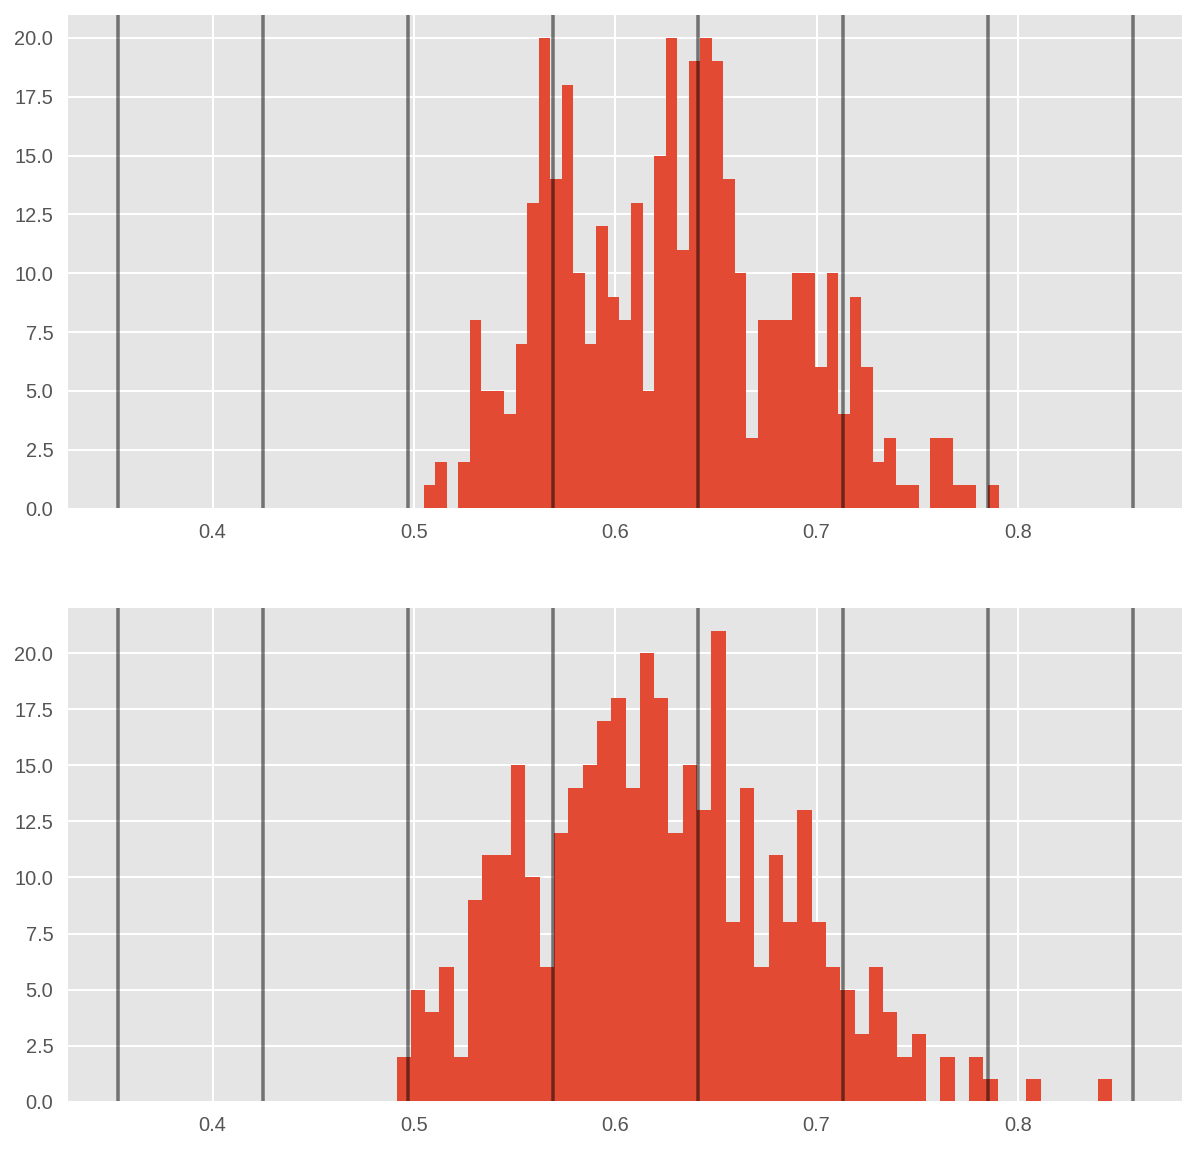

In [19]:
fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(ocl_fixations['centre_x'], bins = 50)
draw_cues(ax1)

ax2 = fig.add_subplot(212, sharex = ax1)
ax2.hist(onl_fixations['centre_x'], bins = 50)
draw_cues(ax2)

plt.show()

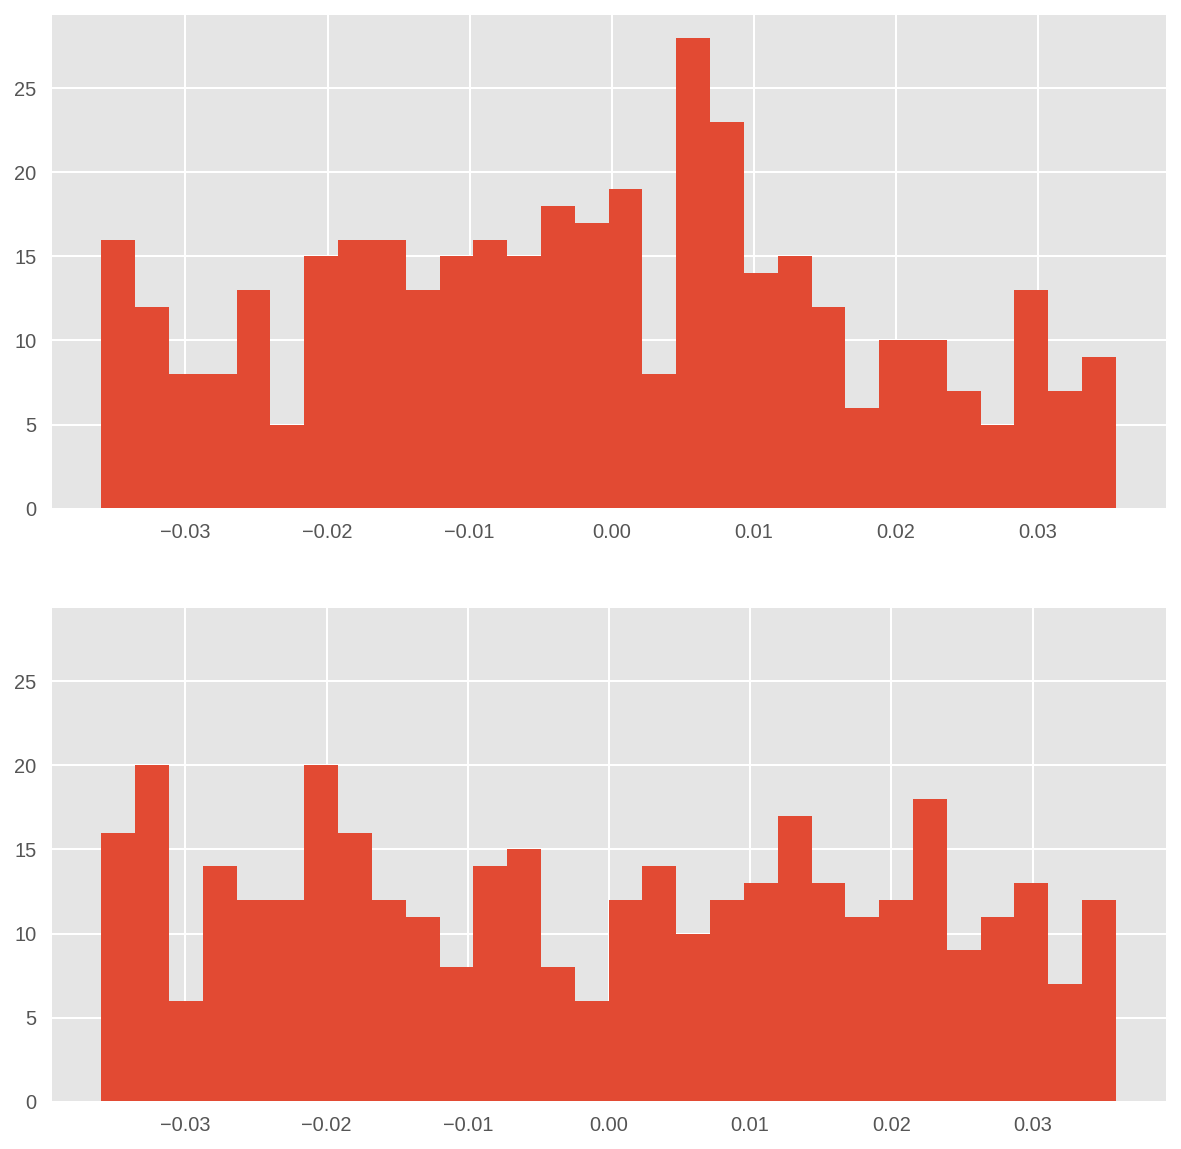

In [20]:
# Overlay the cues & plot the closest fixations. 0 = cue position

x1 = ocl_fixations['distance_to']
x2 = onl_fixations['distance_to']

fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(x1, bins = 30)
ax2 = fig.add_subplot(212, sharey = ax1)
ax2.hist(x2, bins = 30)
plt.show()

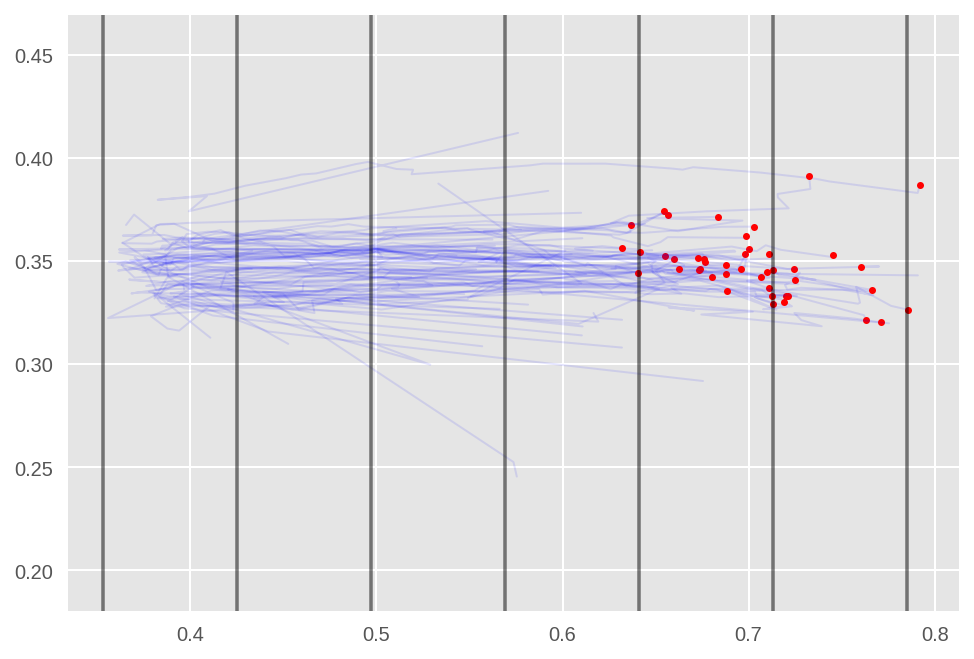

In [21]:

for subj in d.values():
    for trial in subj['trials'].values():
        if 'Occlusion_Cue_LeftToRight' in trial['name']:
            plt.plot(trial['fix']['centre_x'], trial['fix']['centre_z'], 'b-', alpha = 0.1, linewidth = 1)
            plt.plot(trial['fix']['centre_x'][-1], trial['fix']['centre_z'][-1], 'r.')

draw_cues(plt.gca(), ybottom = 0.18, ytop = 0.48)
plt.ylim(0.18, 0.47)
plt.show()

In [22]:
# Kolmogorov-Smirnov two-sample test for ocl vs onl

res = ks_2samp(x1, x2)
print 'ks = {}\np = {}'.format(round(res[0], 4), round(res[1], 4))

ks = 0.0979
p = 0.0482


### Fixations' location during reach

In [23]:
ocl_fix_reach = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 2)]

ocl_fix_final = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 3)]


onl_fix_reach = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 2)]

onl_fix_final = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 3)]

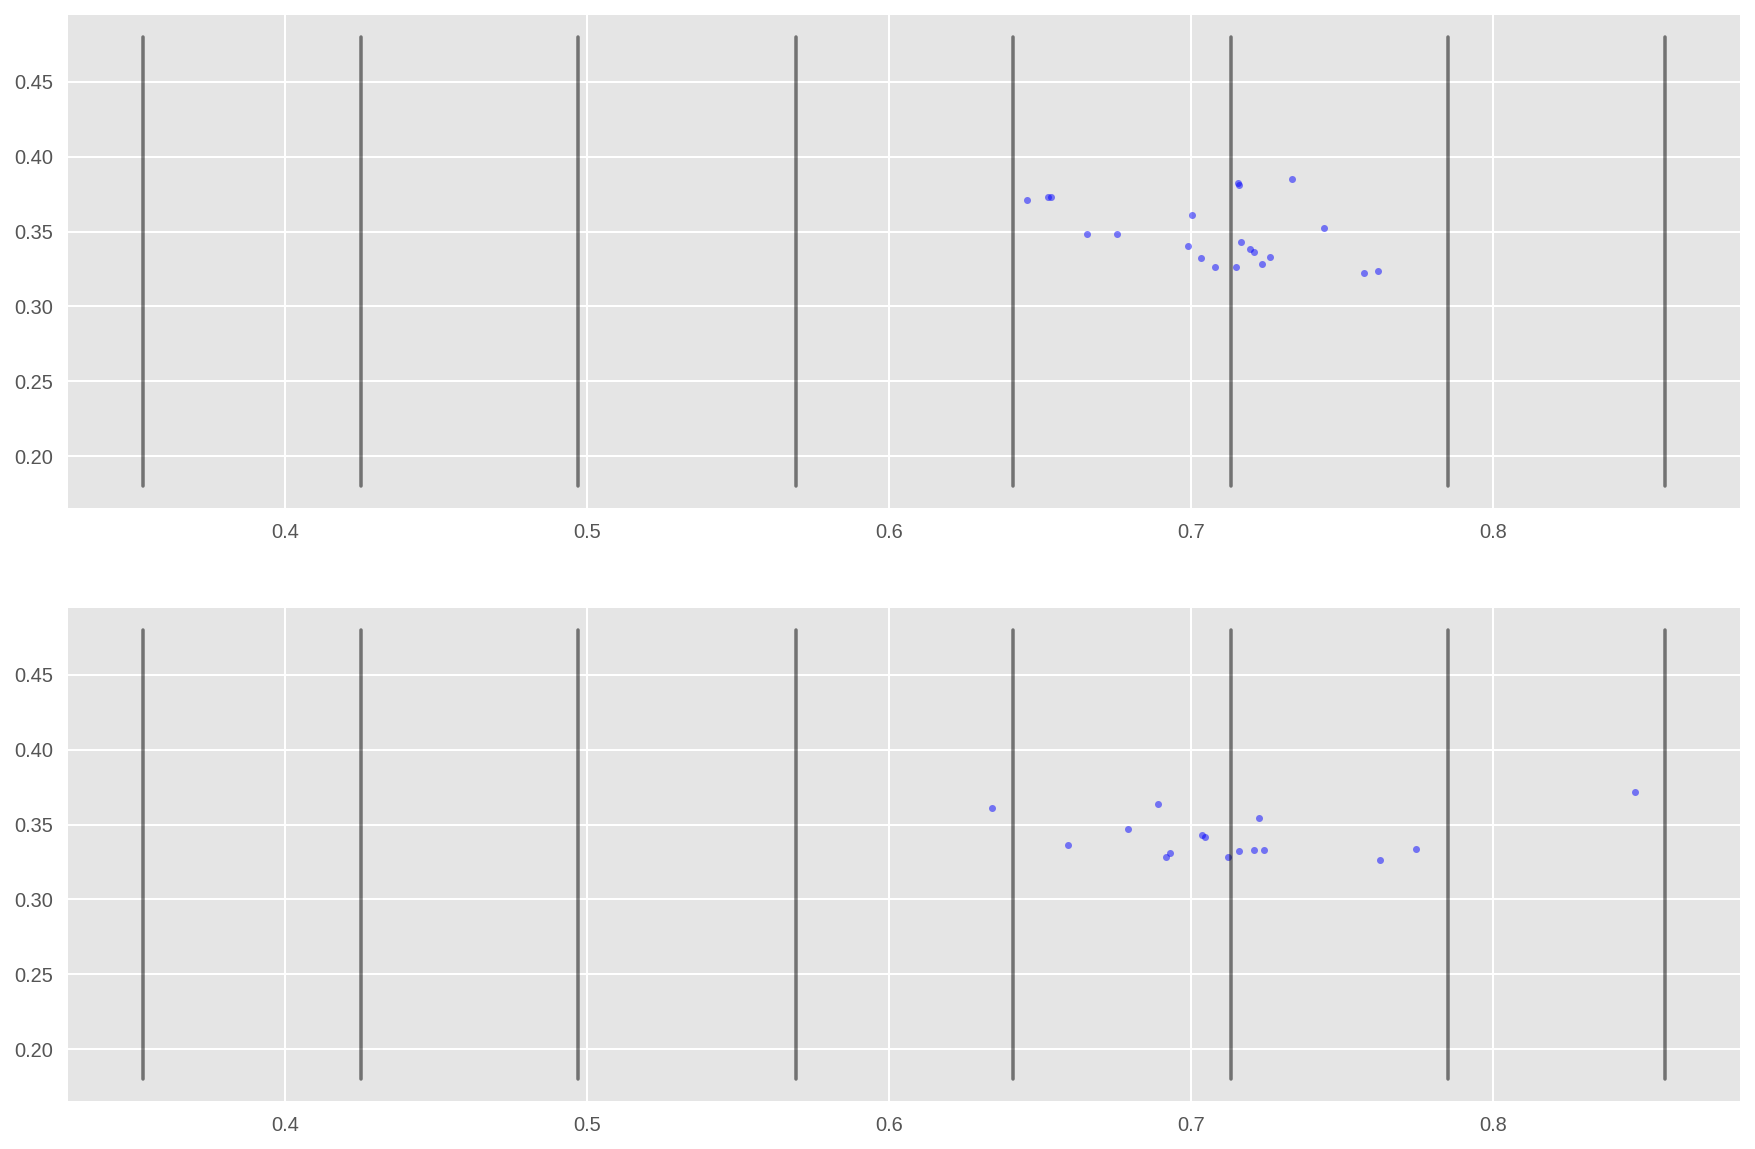

In [24]:
# Fixations after the reach onset

fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.plot(ocl_fix_reach['centre_x'], ocl_fix_reach['centre_z'], 'b.', alpha = 0.5)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.set_xlim(0.34, 0.87)
ax1.set_ylim(0.18, 0.48)

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.plot(onl_fix_reach['centre_x'], onl_fix_reach['centre_z'], 'b.', alpha = 0.5)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)

plt.show()

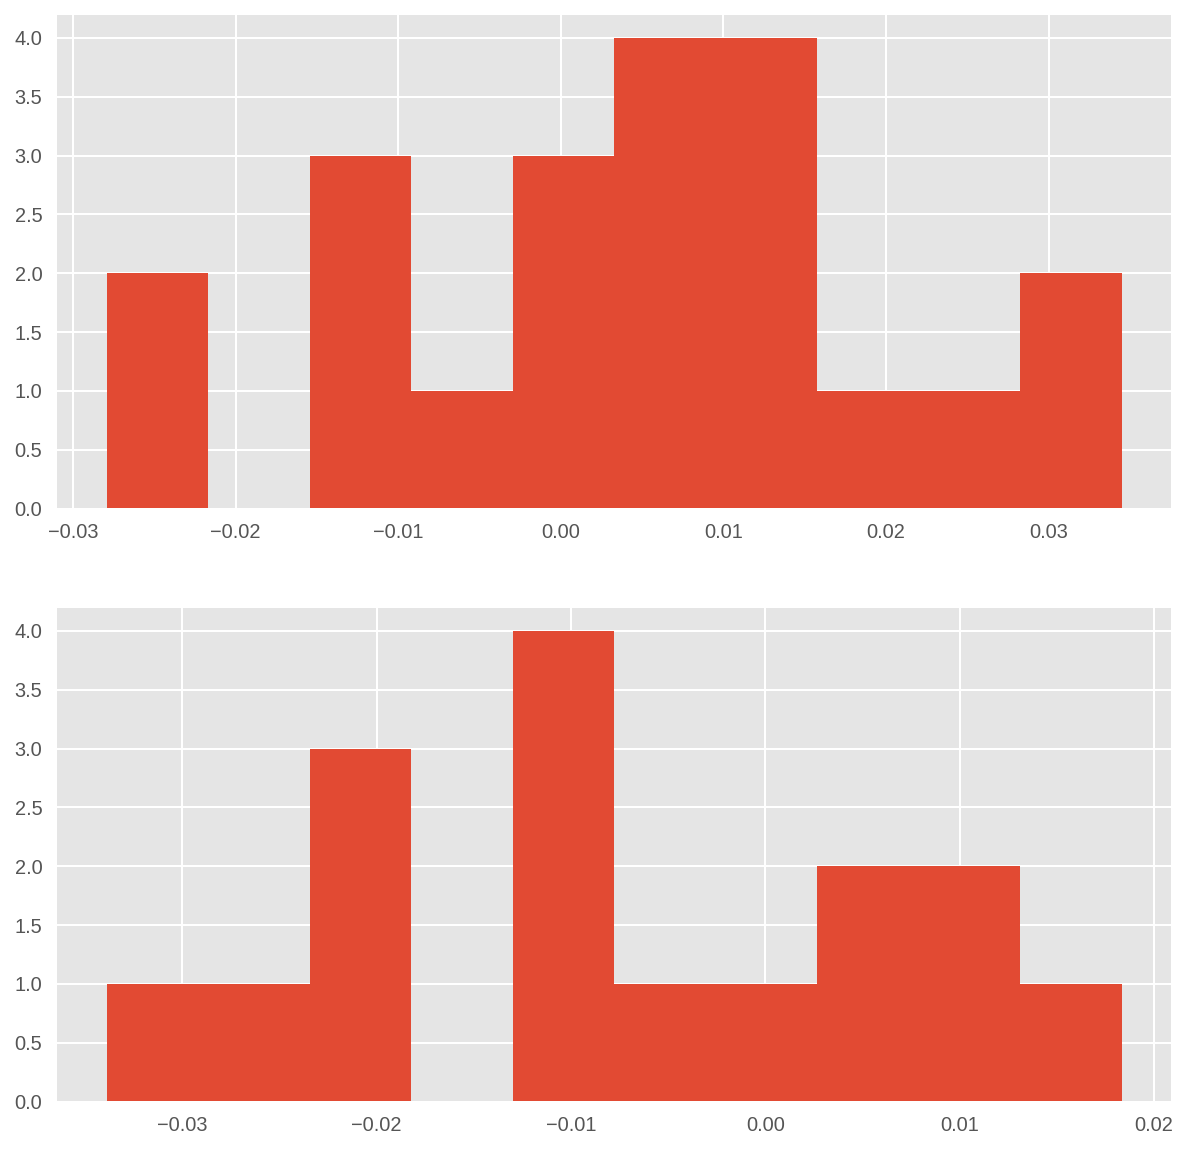

In [25]:
# Distribution relative to the cue

x1 = ocl_fix_reach['distance_to']
x2 = onl_fix_reach['distance_to']

fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(x1, bins = 10)
ax2 = fig.add_subplot(212, sharey = ax1)
ax2.hist(x2, bins = 10)
plt.show()

### -------------------- Fixations' duration --------------------

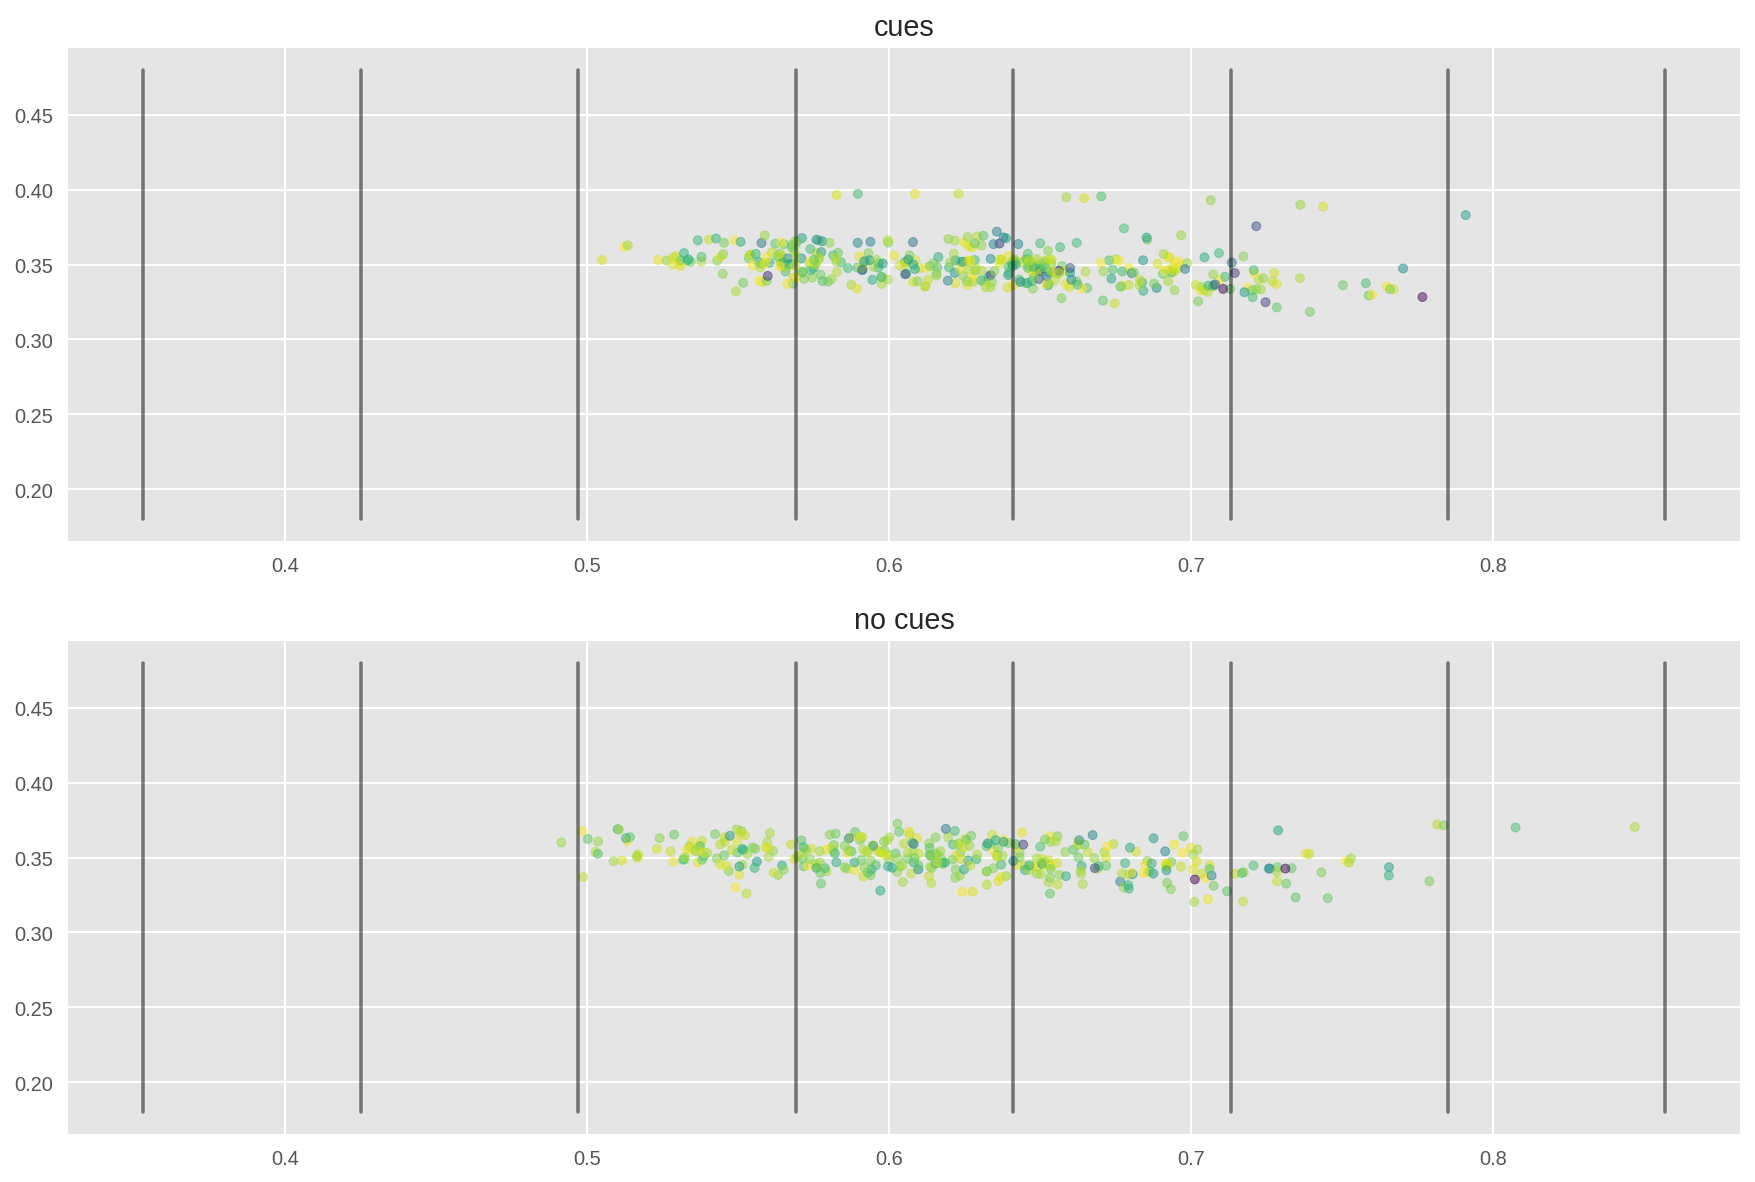

In [26]:
from matplotlib import cm

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.scatter(ocl_fixations['centre_x'], ocl_fixations['centre_z'], c = ocl_fixations['duration'],
            alpha = 0.5, cmap = cm.viridis_r, s = 20)
ax1.set_title('cues')
# ax1.set_xlim(0.5, 0.8)
# ax1.set_ylim(0.3, 0.4)

ax2 = fig.add_subplot(212)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)
ax2.scatter(onl_fixations['centre_x'], onl_fixations['centre_z'], c = onl_fixations['duration'],
            alpha = 0.5, cmap = cm.viridis_r, s = 20)
ax2.set_title('no cues')

plt.show()

r = -0.091
p = 0.072


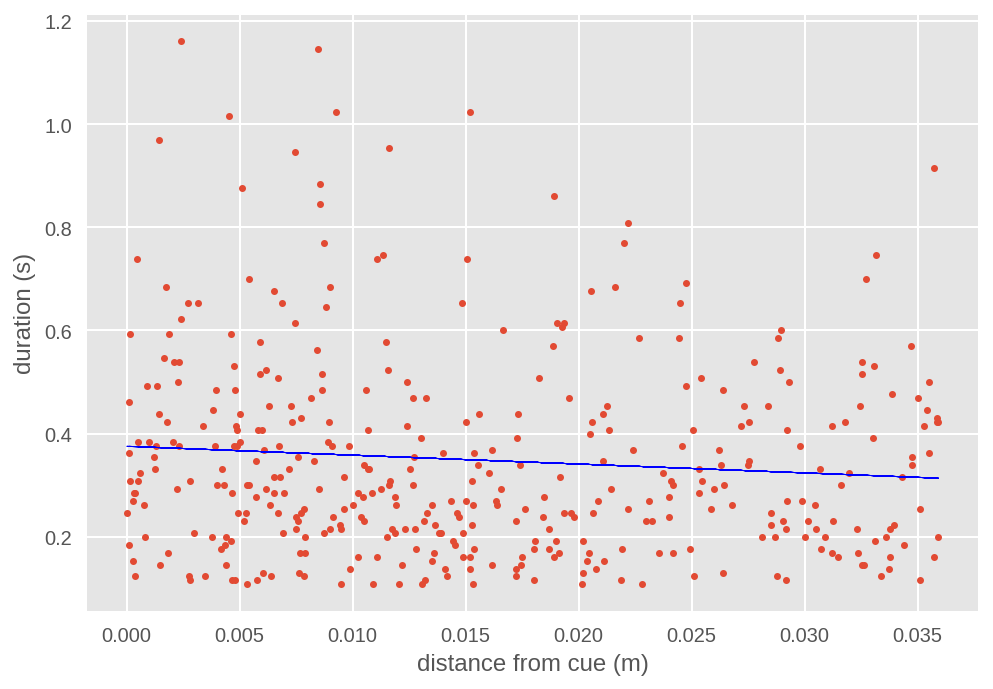

In [27]:
# Linear model duration ~ distance for ocl

from scipy.stats import linregress

slope, intercept, r, p, stderr = linregress(abs(ocl_fixations['distance_to']), ocl_fixations['duration'])
print 'r = {}\np = {}'.format(round(r, 3), round(p, 3))
y = slope * abs(ocl_fixations['distance_to']) + intercept

plt.plot(abs(ocl_fixations['distance_to']), ocl_fixations['duration'], '.')
plt.plot(abs(ocl_fixations['distance_to']), y, 'b-', linewidth = 0.5)
plt.xlabel('distance from cue (m)')
plt.ylabel('duration (s)')
plt.show()

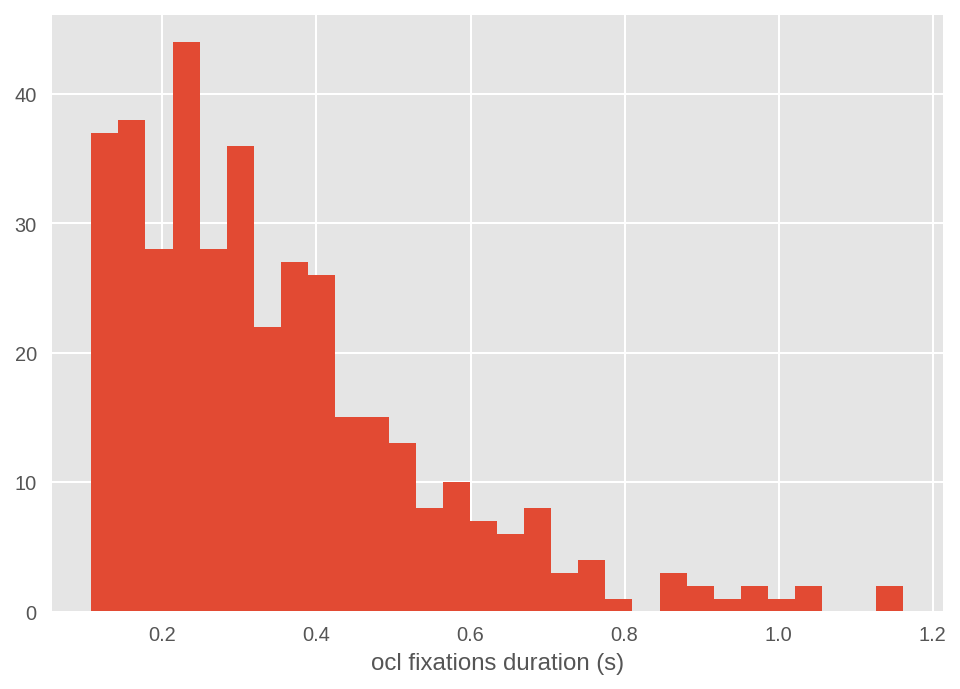

In [28]:
# Distribution of fixations' duration

plt.hist(ocl_fixations['duration'], bins = 30)
plt.xlabel('ocl fixations duration (s)')
plt.show()

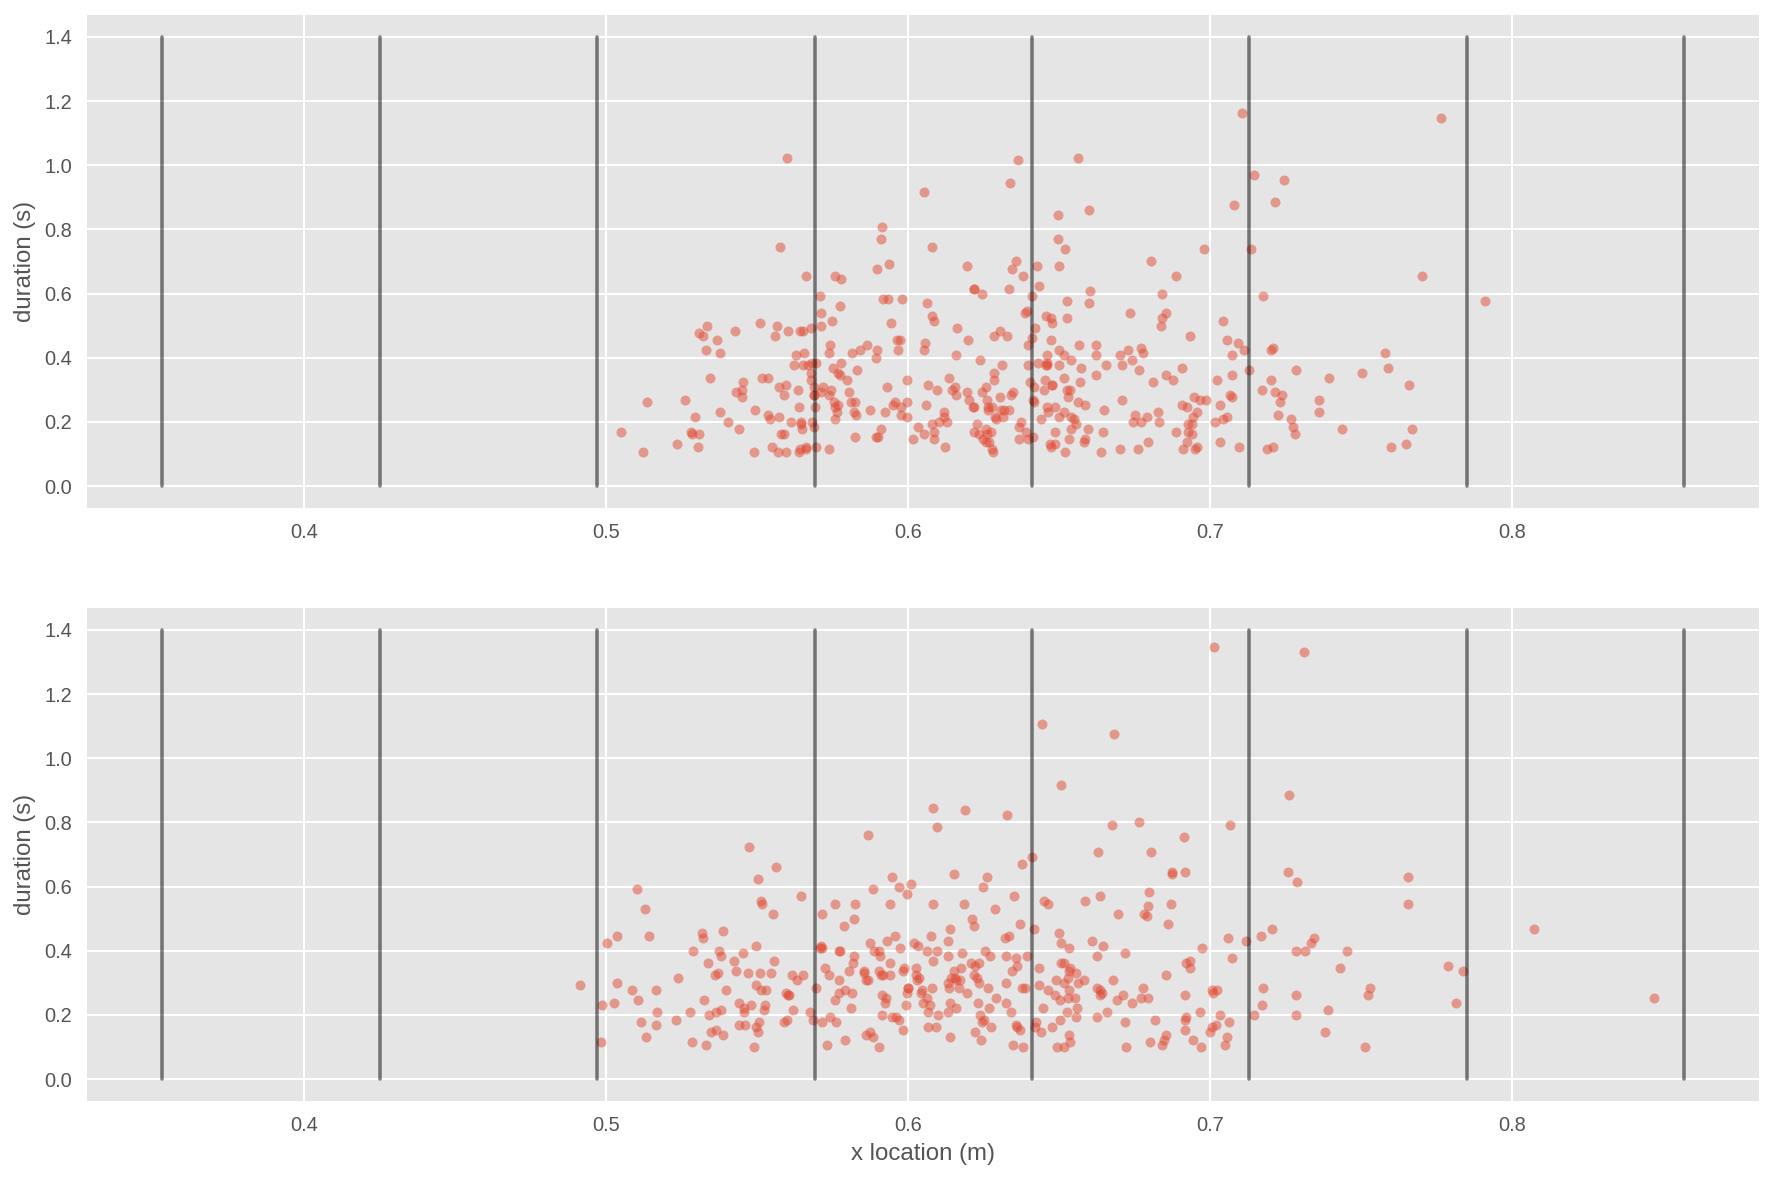

In [29]:
# Fixation duration against location on the x-axis

fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.plot(ocl_fixations['centre_x'], ocl_fixations['duration'], '.', markersize = 10, alpha = 0.5)
draw_cues(ax1, ybottom = 0, ytop = 1.4)
ax1.set_ylabel('duration (s)')

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.plot(onl_fixations['centre_x'], onl_fixations['duration'], '.', markersize = 10, alpha = 0.5)
draw_cues(ax2, ybottom = 0, ytop = 1.4)
ax2.set_xlabel('x location (m)')
ax2.set_ylabel('duration (s)')

plt.show()

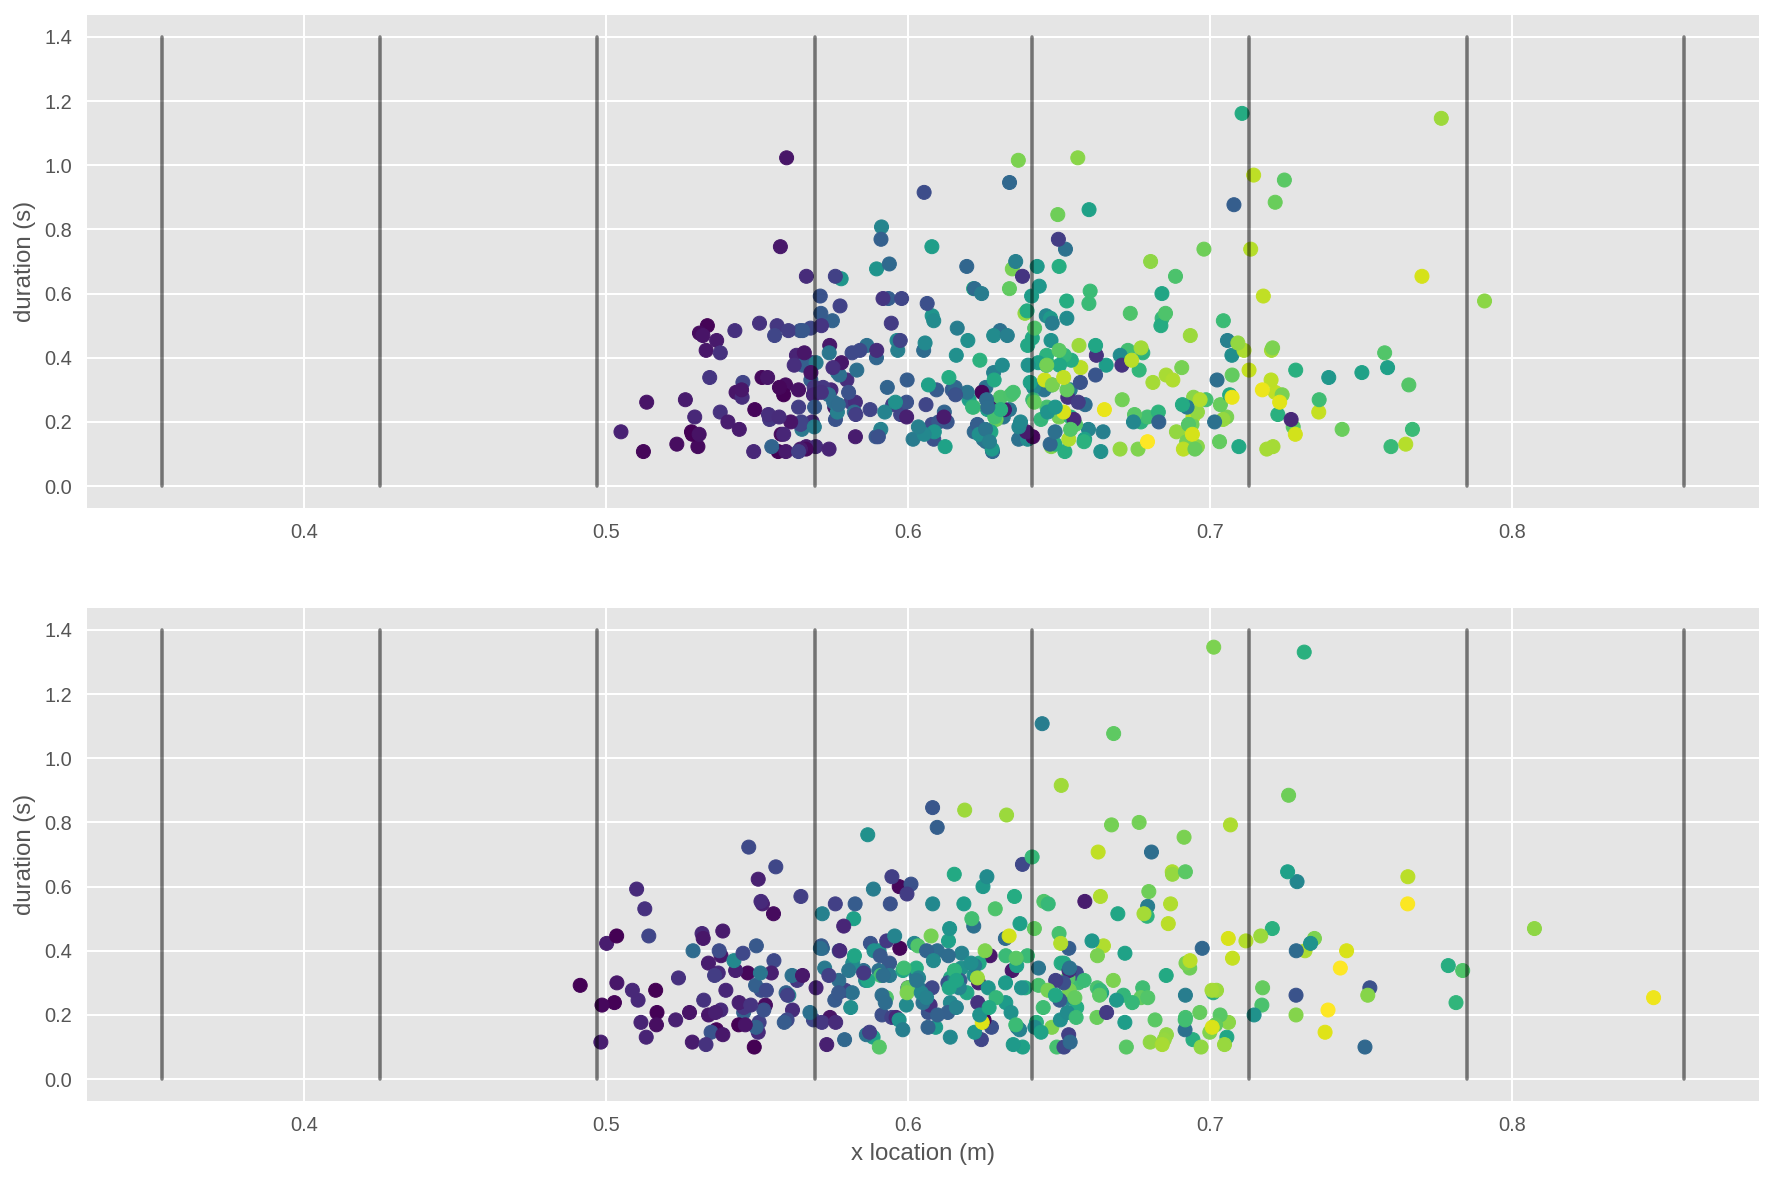

In [30]:
fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.scatter(ocl_fixations['centre_x'], ocl_fixations['duration'], c = ocl_fixations['start_frame'], cmap = cm.viridis)
draw_cues(ax1, ybottom = 0, ytop = 1.4)
ax1.set_ylabel('duration (s)')

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.scatter(onl_fixations['centre_x'], onl_fixations['duration'], c = onl_fixations['start_frame'], cmap = cm.viridis)
draw_cues(ax2, ybottom = 0, ytop = 1.4)
ax2.set_xlabel('x location (m)')
ax2.set_ylabel('duration (s)')

plt.show()

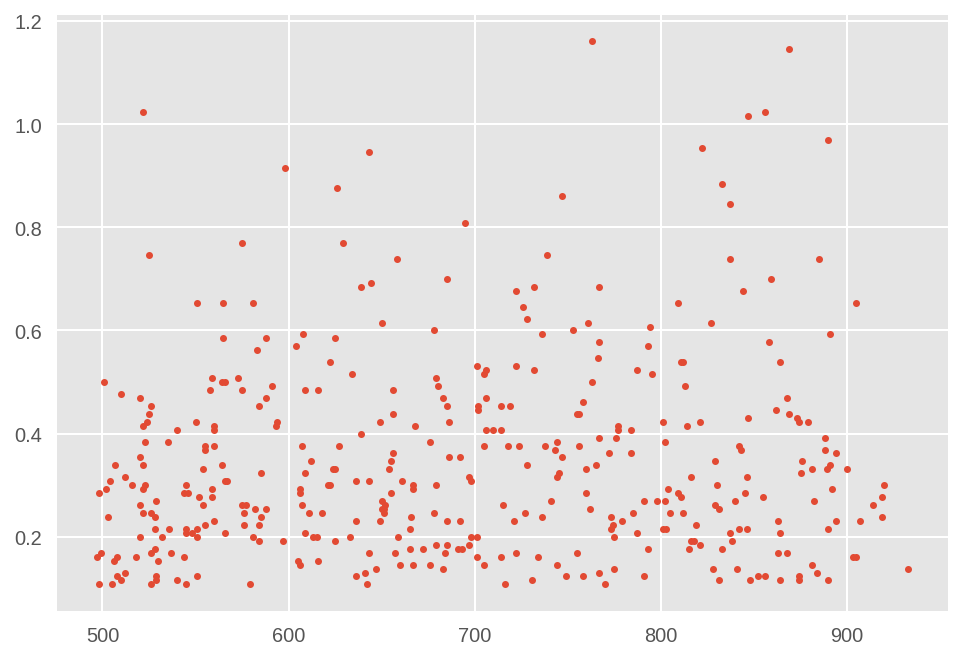

In [31]:
plt.plot(ocl_fixations['start_frame'], ocl_fixations['duration'], '.')
plt.show()

## Reaching movement

In [32]:
def auc(x, y, z):
    vel = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) # in m/frame. divide by sampling freq to get m/s
    d = sum(vel)
    return d

In [33]:
# Find the reach travel distance for wrist

td = pd.DataFrame(columns = ['participant', 'condition', 'travel_distance'])

for pid, subj in d.items():
    for trial in subj['trials'].values():
        
        x = trial[markers[pid]['wrist'] + 'x']
        y = trial[markers[pid]['wrist'] + 'y']
        z = trial[markers[pid]['wrist'] + 'z']
        
        dist = auc(x, y, z)
        cond = trial['name'][6:-4]
        
        to_add = pd.Series([pid, cond, dist], td.columns.values.tolist())
        td = td.append(to_add, ignore_index = True)
        
td[:5]

,participant,condition,travel_distance
0,P11,Visible_NoCue_RightToLeft,0.451970
1,P11,Visible_NoCue_RightToLeft,0.455537
2,P11,Visible_NoCue_LeftToRight,0.404022
3,P11,Visible_NoCue_LeftToRight,0.400822
4,P11,Visible_NoCue_LeftToRight,0.389036


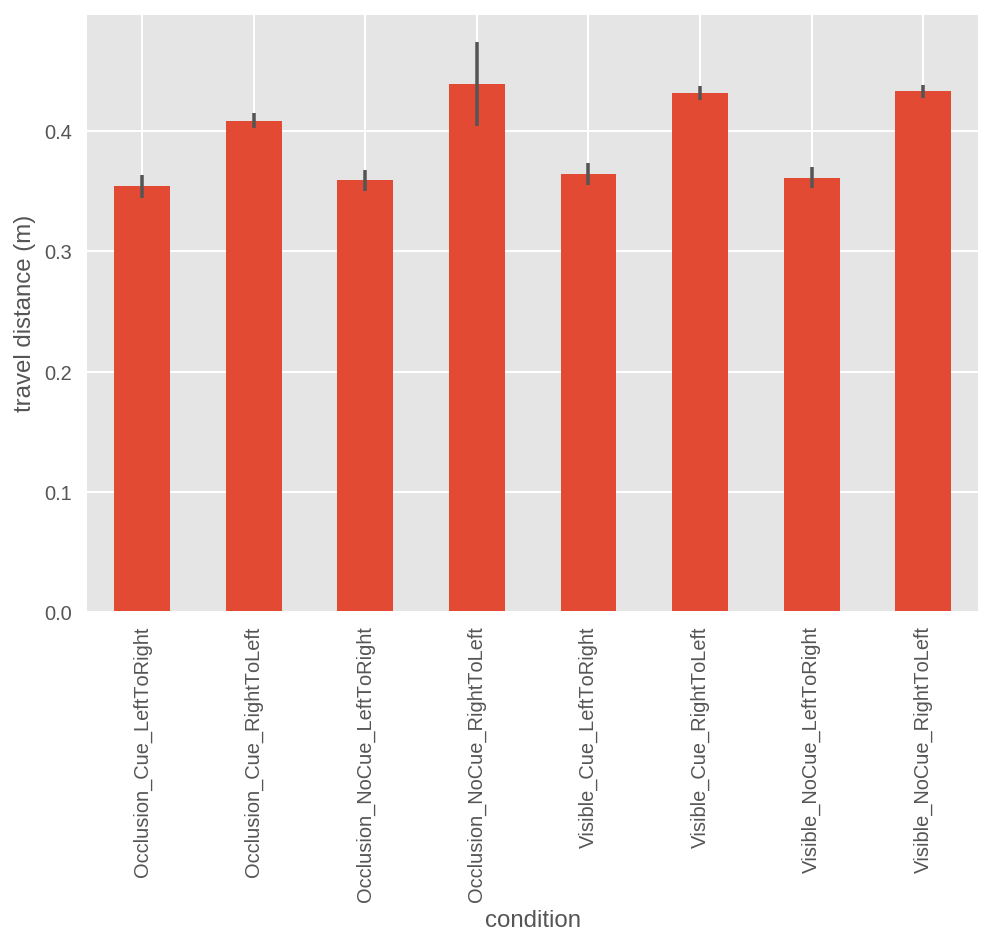

In [34]:
a = td.groupby(['participant', 'condition']).aggregate(np.mean).reset_index()
b = a.pivot(index = 'participant', columns = 'condition', values = 'travel_distance')
c = b.mean(axis = 0)
# b.loc[:, ['Occlusion_Cue_LeftToRight', 'Visible_Cue_LeftToRight']].plot(kind = 'bar')
c.plot(kind = 'bar',  yerr = b.std(axis = 0) / np.sqrt(len(b)))
plt.ylabel('travel distance (m)')
plt.show()

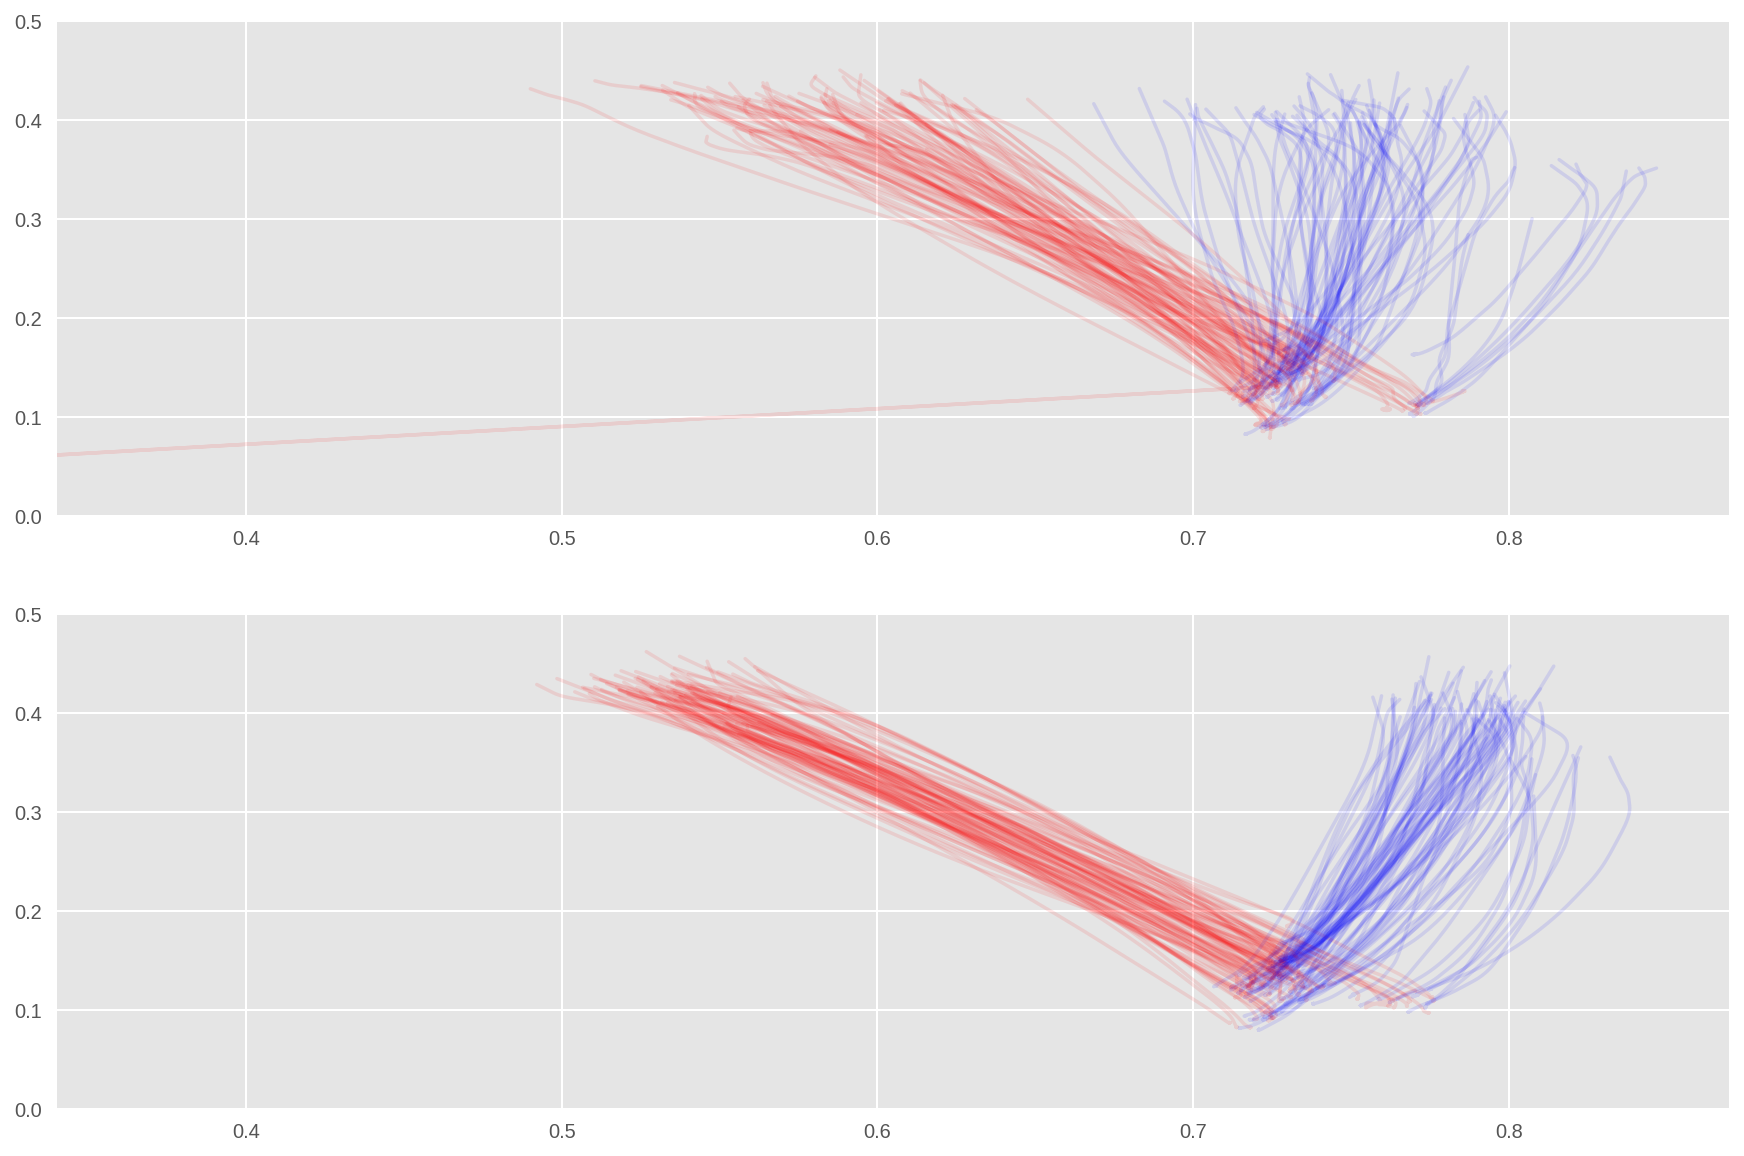

In [35]:
# Reach trajectories on x-y axes for wrist

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for pid, subj in d.items():
    for trial in subj['trials'].values():
        x = trial[markers[pid]['wrist'] + 'x']
        y = trial[markers[pid]['wrist'] + 'y']
        if 'Occlusion_Cue_LeftToRight' in trial['name'] or 'Occlusion_NoCue_LeftToRight' in trial['name']:
            ax1.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Occlusion_Cue_RightToLeft' in trial['name'] or 'Occlusion_NoCue_RightToLeft' in trial['name']:
            ax1.plot(x, y, color = 'r', alpha = 0.1)
        elif 'Visible_Cue_LeftToRight' in trial['name'] or 'Visible_NoCue_LeftToRight' in trial['name']:
            ax2.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Visible_Cue_RightToLeft' in trial['name'] or 'Visible_NoCue_RightToLeft' in trial['name']:
            ax2.plot(x, y, color = 'r', alpha = 0.1)

ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax1.set_xlim(0.34, 0.87)
ax2.set_xlim(0.34, 0.87)
plt.show()

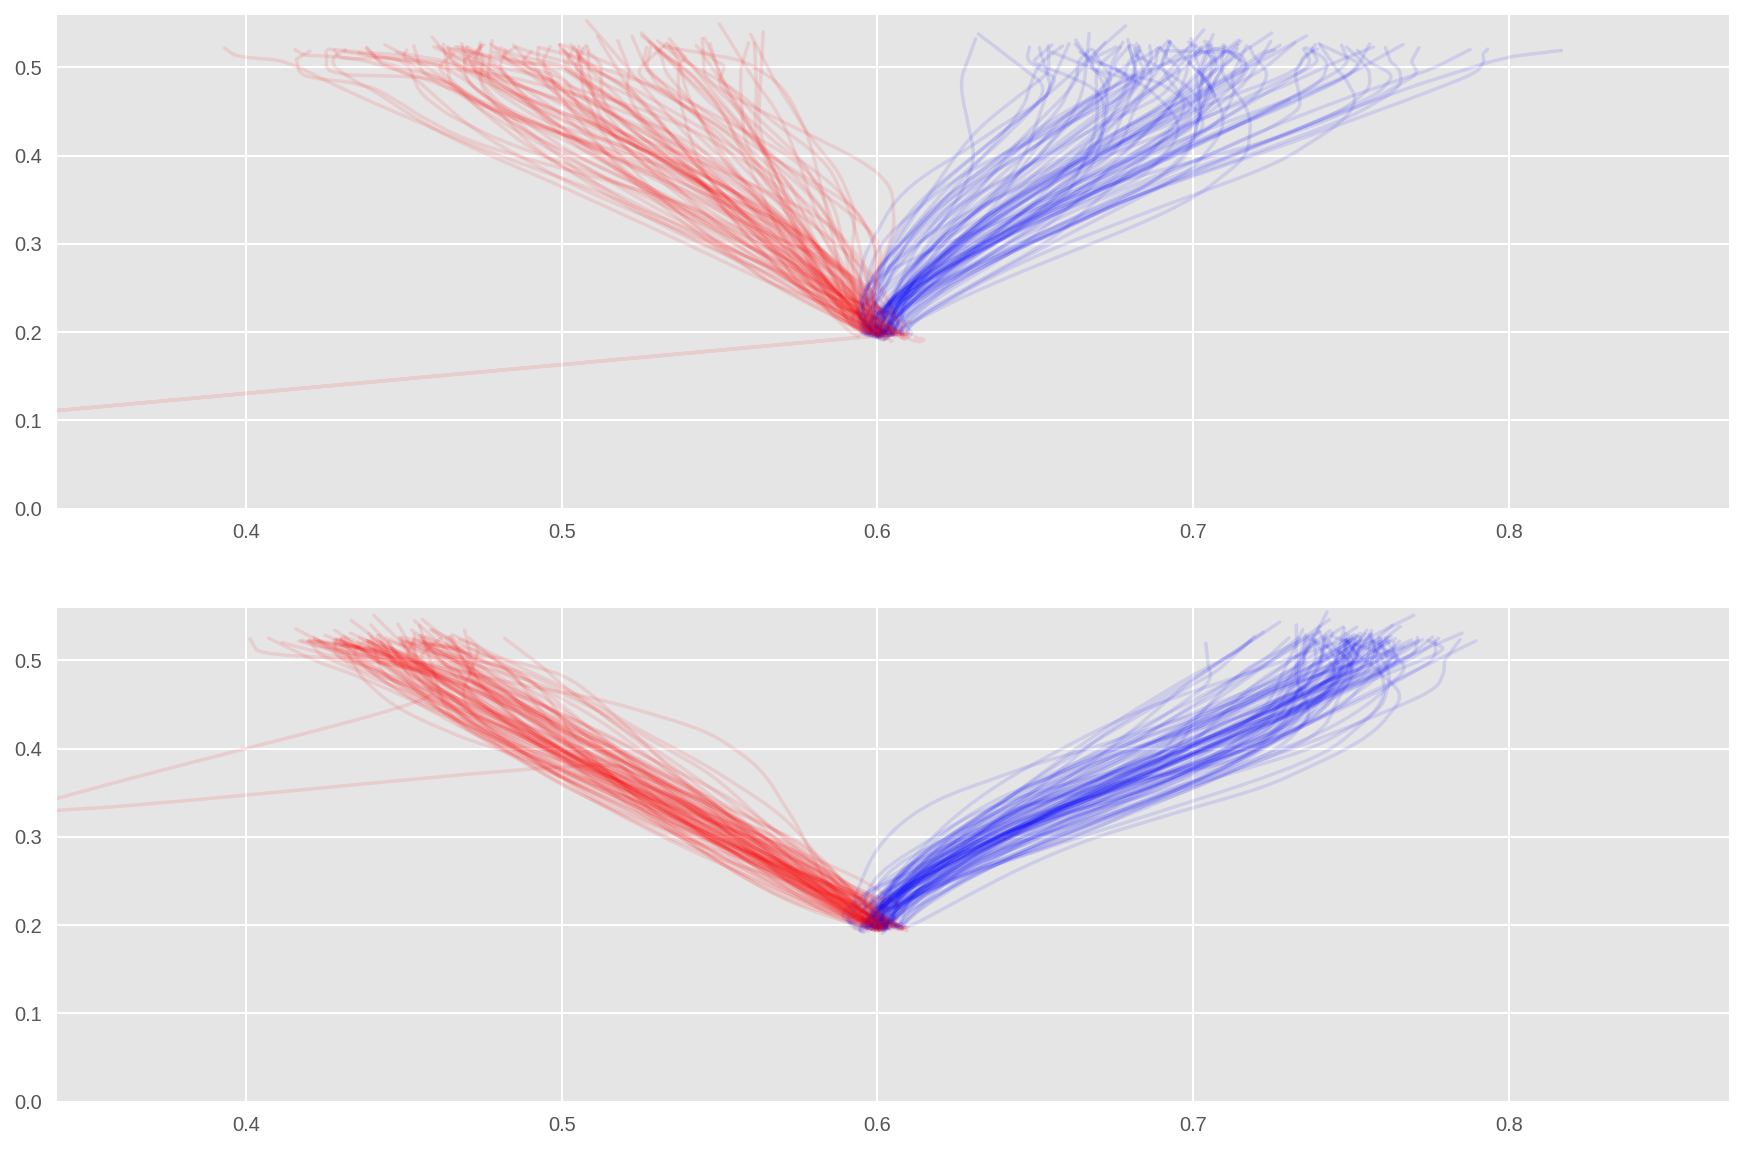

In [36]:
# Reach trajectories on x-y axes for index

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for pid, subj in d.items():
    for trial in subj['trials'].values():
        x = trial[markers[pid]['index'] + 'x']
        y = trial[markers[pid]['index'] + 'y']
        if 'Occlusion_Cue_LeftToRight' in trial['name'] or 'Occlusion_NoCue_LeftToRight' in trial['name']:
            ax1.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Occlusion_Cue_RightToLeft' in trial['name'] or 'Occlusion_NoCue_RightToLeft' in trial['name']:
            ax1.plot(x, y, color = 'r', alpha = 0.1)
        elif 'Visible_Cue_LeftToRight' in trial['name'] or 'Visible_NoCue_LeftToRight' in trial['name']:
            ax2.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Visible_Cue_RightToLeft' in trial['name'] or 'Visible_NoCue_RightToLeft' in trial['name']:
            ax2.plot(x, y, color = 'r', alpha = 0.1)

ax1.set_ylim(0, 0.56)
ax2.set_ylim(0, 0.56)
ax1.set_xlim(0.34, 0.87)
ax2.set_xlim(0.34, 0.87)
plt.show()

In [37]:
# Get the index accuracy and mean distance of fixations table

mean_fixations = fixations.groupby(['p', 'trial'])['distance_to'] \
                          .apply(lambda x: np.mean(np.abs(x))) \
                          .reset_index()

In [38]:
common = pd.merge(mean_fixations, accuracies, on = ['p', 'trial'])
display(common[:10])

ocl = common[common['condition'] == 'Occlusion_Cue_LeftToRight']
onl = common[common['condition'] == 'Occlusion_NoCue_LeftToRight']

,p,trial,distance_to,condition,eyes_object_final,eyes_object_ro,index_object,peak_vel,reach_duration,reaction,ro_frame,wrist_decel
0,P07,t1,0.017805,Occlusion_Cue_LeftToRight,-0.096329,-0.062740,-0.062737,975.0,63.0,64.0,944.0,32.0
1,P07,t10,0.012794,Occlusion_Cue_RightToLeft,-0.058725,-0.024311,-0.059111,978.0,71.0,60.0,940.0,33.0
2,P07,t11,0.014703,Occlusion_Cue_RightToLeft,-0.075704,-0.030204,-0.073226,975.0,92.0,56.0,936.0,53.0
3,P07,t12,0.016460,Occlusion_Cue_RightToLeft,-0.090795,-0.045553,-0.071911,992.0,107.0,66.0,946.0,61.0
4,P07,t13,0.021122,Occlusion_NoCue_LeftToRight,-0.007270,0.008044,-0.009502,963.0,72.0,42.0,922.0,31.0
5,P07,t15,0.021613,Occlusion_NoCue_LeftToRight,-0.099761,-0.065825,-0.094429,958.0,91.0,41.0,921.0,54.0
6,P07,t16,0.018427,Occlusion_NoCue_LeftToRight,-0.057885,-0.042634,-0.040204,972.0,94.0,48.0,928.0,50.0
7,P07,t17,0.017600,Occlusion_NoCue_LeftToRight,-0.054586,-0.017586,-0.060545,955.0,75.0,47.0,927.0,47.0
8,P07,t18,0.018002,Occlusion_NoCue_LeftToRight,-0.056217,-0.028486,-0.073183,975.0,91.0,49.0,929.0,45.0
9,P07,t19,0.018782,Occlusion_NoCue_RightToLeft,-0.052930,0.000871,-0.055344,980.0,102.0,59.0,939.0,61.0


r = -0.13
p = 0.398


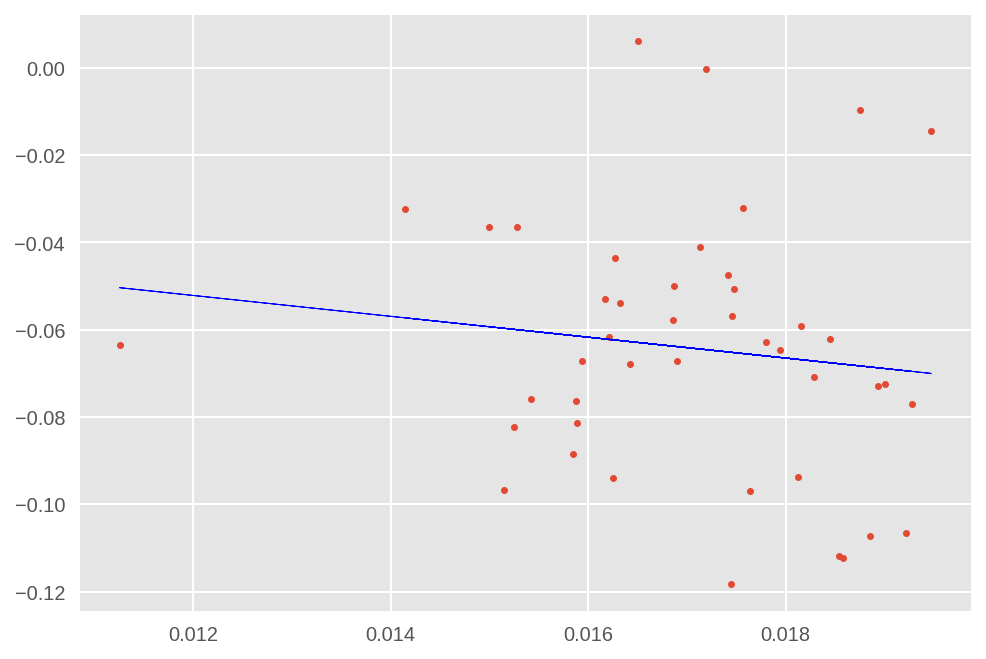

In [40]:
slope, intercept, r, p, stderr = linregress(ocl['distance_to'], ocl['index_object'])
print 'r = {}\np = {}'.format(round(r, 2), round(p, 3))

y = intercept + slope * ocl['distance_to']

plt.plot(ocl['distance_to'], ocl['index_object'], '.')
plt.plot(ocl['distance_to'], y, 'b-', linewidth = 0.5)
plt.show()